In [ ]:
import tensorflow as tf
import pickle
from pathlib import Path
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Paths
save_dir = Path("/content/drive/MyDrive/EmotionDetection_Fixed")
save_dir.mkdir(parents=True, exist_ok=True)

# ---- Load metadata ----
meta_path = "/content/drive/MyDrive/EmotionDetection_Trained/EfficientNetB0_metadata.pkl"
with open(meta_path, "rb") as f:
    meta = pickle.load(f)

num_classes = len(meta["emotion_labels"])
print(f"Detected emotion classes: {meta['emotion_labels']}")

# ---- Rebuild EfficientNet for grayscale input ----
inp = Input(shape=(225, 225, 1))  # grayscale input
x = tf.keras.layers.Conv2D(3, (3, 3), padding="same")(inp)  # map grayscale → 3 channels

# ⚠️ IMPORTANT: use weights=None (not imagenet)
base_model = EfficientNetB0(weights=None, include_top=False, input_tensor=x)

# Freeze base model (optional — you can unfreeze for fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Classification head
h = GlobalAveragePooling2D()(base_model.output)
h = Dense(128, activation="relu")(h)
h = Dropout(0.4)(h)
out = Dense(num_classes, activation="softmax")(h)

model = Model(inp, out, name="EfficientNetB0_fixed_gray")
print("✅ Model built successfully!")
print("Input shape:", model.input_shape)

# ---- Save fixed model ----
model_path = save_dir / "EfficientNetB0_emotion_model.keras"
model.save(model_path)
print(f"💾 Saved fixed EfficientNetB0 (grayscale-compatible): {model_path}")

# ---- Save metadata ----
meta_save = save_dir / "EfficientNetB0_metadata.pkl"
with open(meta_save, "wb") as f:
    pickle.dump(meta, f)
print(f"🧾 Saved metadata: {meta_save}")


Detected emotion classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
✅ Model built successfully!
Input shape: (None, 225, 225, 1)
💾 Saved fixed EfficientNetB0 (grayscale-compatible): /content/drive/MyDrive/EmotionDetection_Fixed/EfficientNetB0_emotion_model.keras
🧾 Saved metadata: /content/drive/MyDrive/EmotionDetection_Fixed/EfficientNetB0_metadata.pkl


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 168 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step


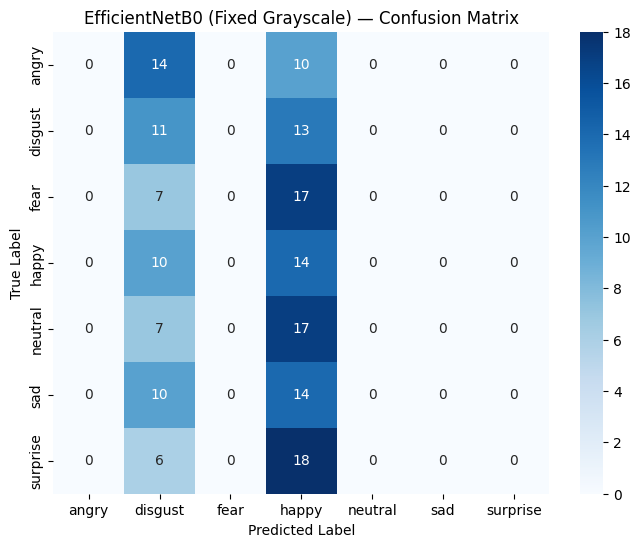


Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        24
     disgust       0.17      0.46      0.25        24
        fear       0.00      0.00      0.00        24
       happy       0.14      0.58      0.22        24
     neutral       0.00      0.00      0.00        24
         sad       0.00      0.00      0.00        24
    surprise       0.00      0.00      0.00        24

    accuracy                           0.15       168
   macro avg       0.04      0.15      0.07       168
weighted avg       0.04      0.15      0.07       168



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
import tensorflow as tf
import numpy as np
import pickle
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ------------------------------
# Paths
# ------------------------------
model_path = "/content/drive/MyDrive/EmotionDetection_Fixed/EfficientNetB0_emotion_model.keras"
meta_path  = "/content/drive/MyDrive/EmotionDetection_Fixed/EfficientNetB0_metadata.pkl"
test_dir   = "/content/drive/MyDrive/24_images/test"

# ------------------------------
# Load model + metadata
# ------------------------------
model = tf.keras.models.load_model(model_path, compile=False)

with open(meta_path, "rb") as f:
    meta = pickle.load(f)

labels = meta["emotion_labels"]
num_classes = len(labels)
print("Classes:", labels)

# ------------------------------
# Test Data Generator (Grayscale)
# ------------------------------
test_gen = ImageDataGenerator()
test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(225, 225),
    color_mode="grayscale",
    class_mode="categorical",
    shuffle=False,
    batch_size=8
)

# ------------------------------
# Predictions
# ------------------------------
preds = model.predict(test_data, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_data.classes

# ------------------------------
# Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("EfficientNetB0 (Fixed Grayscale) — Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ------------------------------
# Classification Report
# ------------------------------
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))
